# License detector pipeline visualization

In [250]:
import importlib

import matplotlib

from notebooks.utils import cd_git_root, show, show_collage, show_contours

matplotlib.rcParams["savefig.pad_inches"] = 0

cd_git_root()

In [251]:
from datasets.load import load_platesmania

datasets = load_platesmania()
ds = datasets.train

paths = ds.paths
path = [path for path in paths if 'K2-BWB' in path.name][0]

print("path:", path)

path: datasets/03-platesmania/pl_K2-BWB_1.jpg


## Image loading

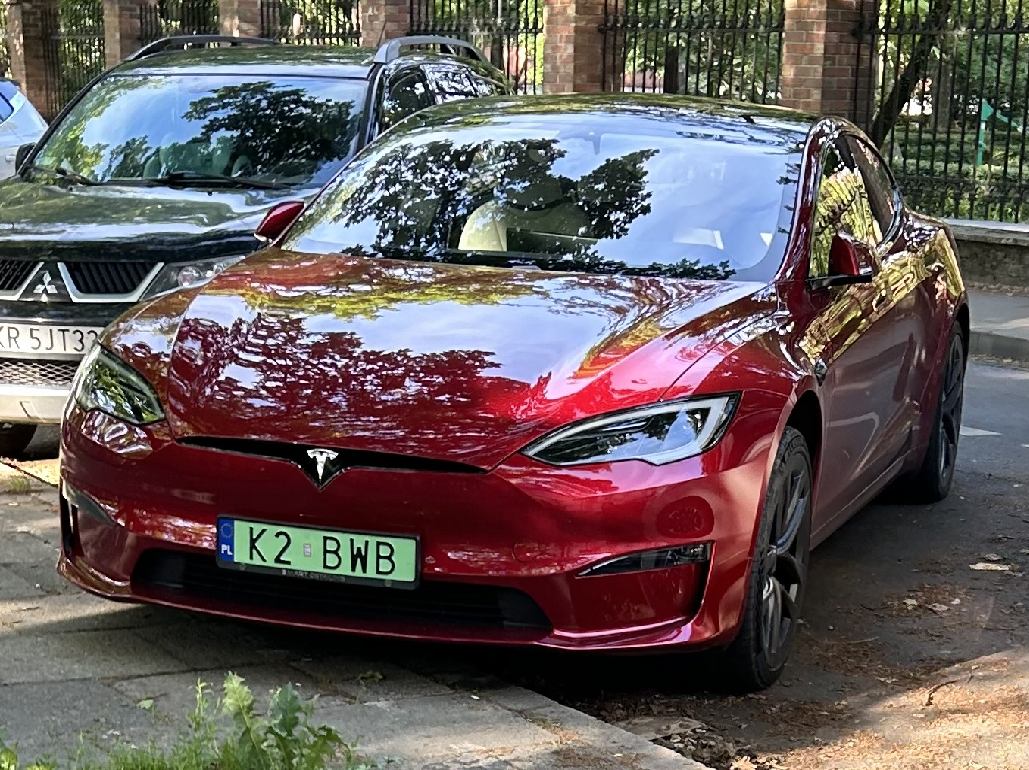

In [252]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

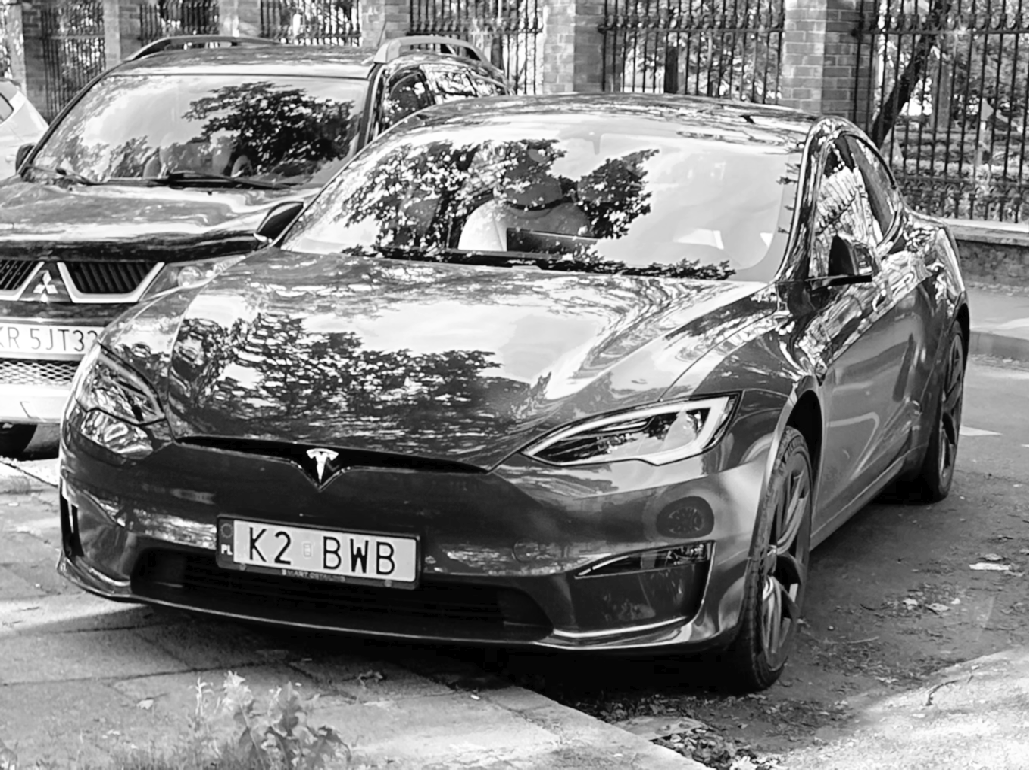

In [253]:
from twm_proj.implementation import initial_filter

importlib.reload(initial_filter)

filtered = initial_filter.InitialFilter().filter(image)
show(filtered)

## Edge filter

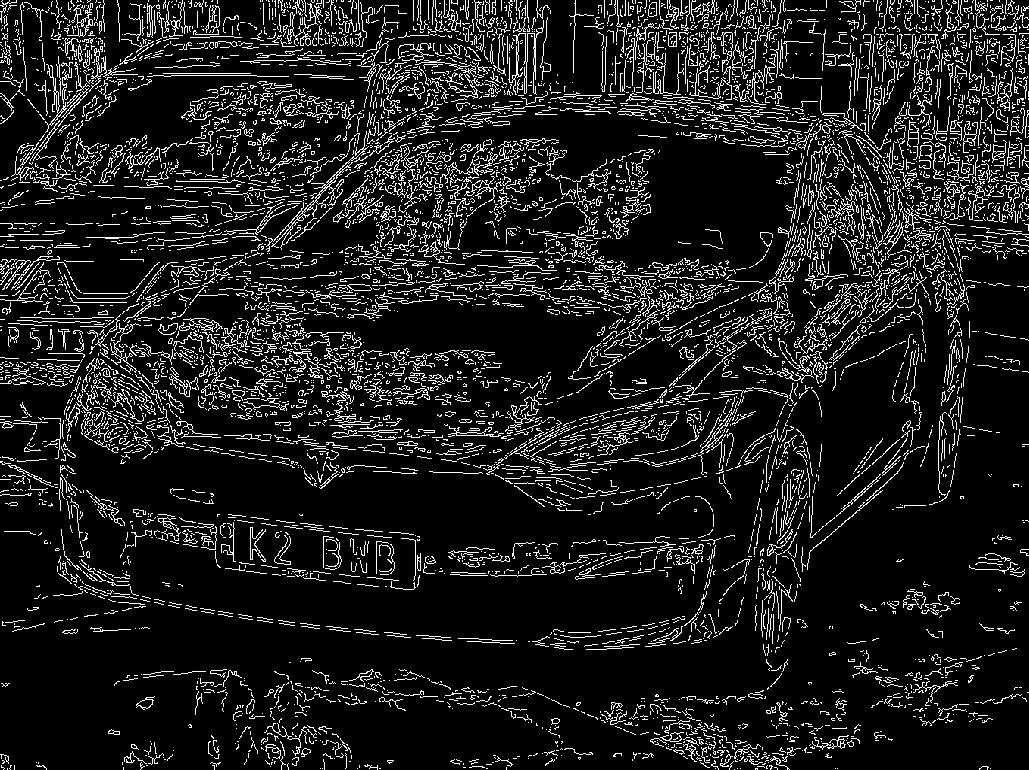

In [254]:
from twm_proj.implementation import edge_filter
importlib.reload(edge_filter)

edges = edge_filter.EdgeFilter().filter(filtered)
show(edges)

## Contour detector

contours count: 159


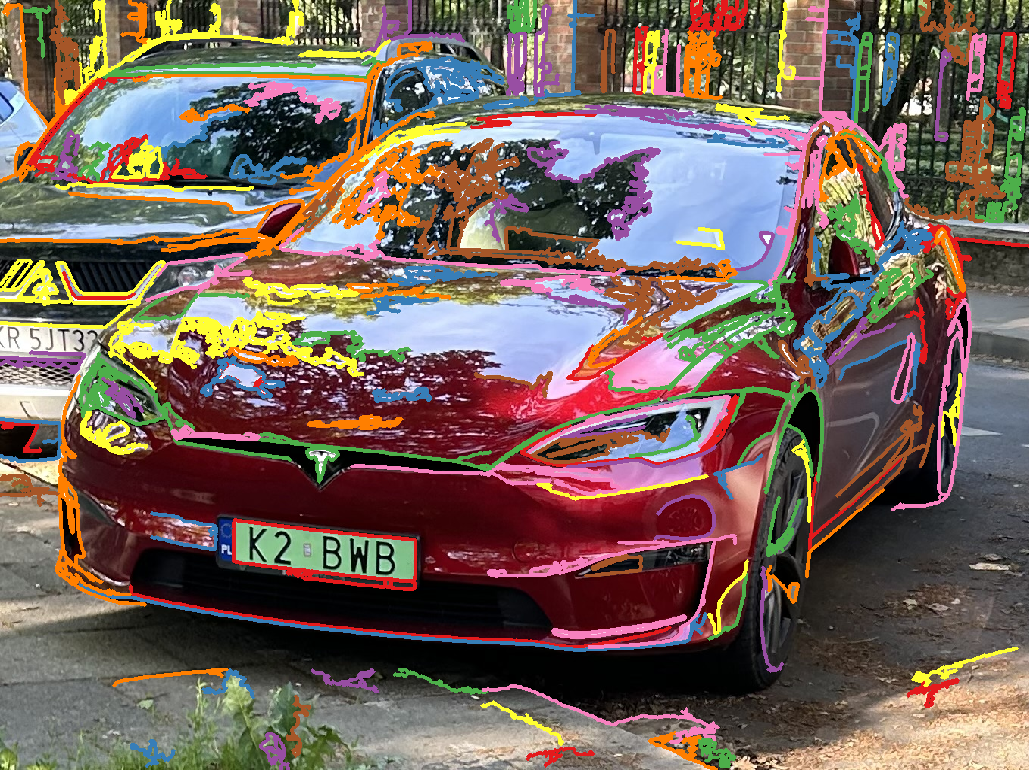

In [255]:
from twm_proj.implementation import contour_detector

from notebooks.utils import filter_by_color

importlib.reload(contour_detector)

contours = [*contour_detector.ContourDetector().detect(edges)]
print("contours count:", len(contours))
filtered_contours = filter_by_color(contours)
show_contours(image, filtered_contours)

## Rectangle detection

rects count: 4
example rect:
 [[309 691]
 [310 747]
 [548 781]
 [546 717]]


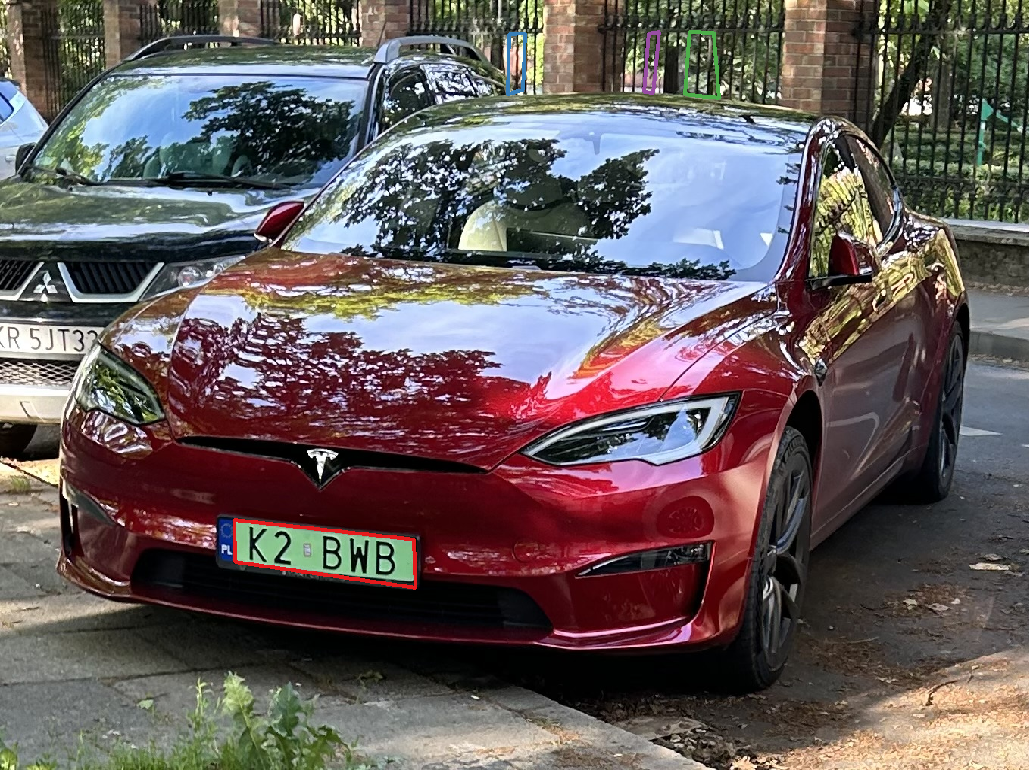

In [256]:
from twm_proj.implementation import rect_detector

importlib.reload(rect_detector)

rects = [rect_detector.RectDetector().detect(contour) for contour in filtered_contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0] if rects else None)
show_contours(image, rects)

## Rectangle de-duplication

In [257]:
from twm_proj.implementation.rect_deduplicator import RectDeduplicator

rect_deduplicator = RectDeduplicator()

rects_deduped = rects

rects_deduped = [
    plate
    for plate in rects
    if not rect_deduplicator.is_dupe(plate[2])
]

print("rects count:", len(rects_deduped))

rects count: 4


## Rectangle transforming

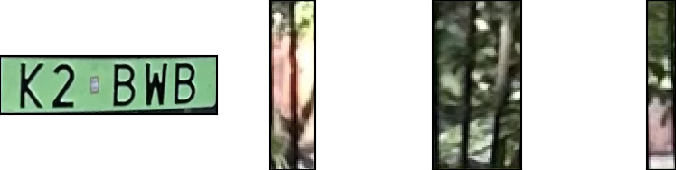

In [258]:
from twm_proj.implementation import rect_transformer

importlib.reload(rect_transformer)

rect_images = [
    rect_transformer.RectTransformer().transform(image, rect) for rect in rects_deduped
]
show_collage(rect_images, height=2)

## Rectangle classification

In [259]:
from twm_proj.interface.rect_classifier import RectangleType
from twm_proj.implementation import rect_classifier

importlib.reload(rect_classifier)

rect_classes = [
    rect_classifier.RectClassifier().classify_with_differences(img)
    for img in rect_images
]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    (rect_img, cls[0], rect)
    for rect_img, cls, rect in zip(rect_images, rect_classes, rects)
    if cls[0] != RectangleType.NOT_PLATE
]

[('ONE_ROW_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.1778846153846154,
   <RectangleType.TWO_ROW_PLATE: 2>: 1.6311475409836065,
   <RectangleType.MINI_PLATE: 3>: 0.35714285714285715}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.942451923076923,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.8158196721311476,
   <RectangleType.MINI_PLATE: 3>: 0.9049999999999999}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.886604774535809,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.6370830977953645,
   <RectangleType.MINI_PLATE: 3>: 0.812807881773399}),
 ('NOT_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.9621082621082622,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.87872900222627,
   <RectangleType.MINI_PLATE: 3>: 0.9374485596707819})]

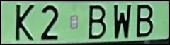

In [260]:
show_collage([plate for plate, _ ,_ in plates], height=2)

## Pre-OCR processing

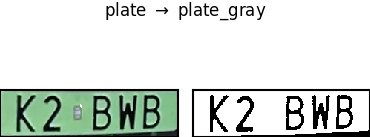

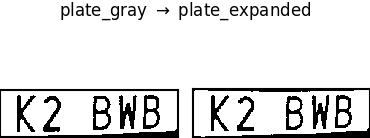

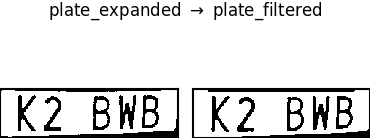

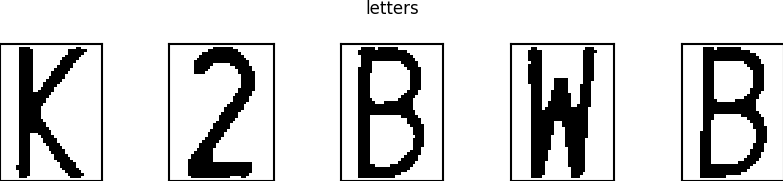

In [261]:
from twm_proj.implementation import pre_ocr

importlib.reload(pre_ocr)

plate_letters = []

for plate, plate_cls, _ in plates:
    plate_gray = pre_ocr.PreOcr().to_grayscale(plate)
    plate_expanded = pre_ocr.PreOcr().expand(plate_gray)
    plate_filtered = pre_ocr.PreOcr().filter_grayscale(plate_expanded)
    letters = [*pre_ocr.PreOcr().get_letters(plate_filtered, plate_cls)]
    grid1 = show_collage([plate, plate_gray], col_wrap=2, height=2)
    grid1.fig.set_tight_layout(True)
    grid1.fig.suptitle("plate $\\rightarrow$ plate_gray")
    grid2 = show_collage([plate_gray, plate_expanded], col_wrap=2, height=2)
    grid2.fig.set_tight_layout(True)
    grid2.fig.suptitle("plate_gray $\\rightarrow$ plate_expanded")
    grid3 = show_collage([plate_expanded, plate_filtered], col_wrap=2, height=2)
    grid3.fig.set_tight_layout(True)
    grid3.fig.suptitle("plate_expanded $\\rightarrow$ plate_filtered")
    if len(letters) > 1:
        grid4 = show_collage(letters, col_wrap=len(letters), height=2)
        grid4.fig.set_tight_layout(True)
        grid4.fig.suptitle("letters")

        plate_letters.append(letters)

## OCR

In [262]:
from twm_proj.implementation.ocr import Ocr


for letters in plate_letters:
    scanned_text = Ocr().scan_text(letters)
    print(scanned_text if scanned_text else None)

K2BWB
